In [1]:
# from torchsr.datasets import Div2K
# from torchsr.models import ninasr_b0
from torchvision.transforms.functional import to_pil_image, to_tensor
from torch.utils.data import Dataset
from torch import nn
import torch
import os
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from PIL import Image


import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

# Autoreload
%reload_ext autoreload
%autoreload 2

# Div2K dataset
# dataset = Div2K(root="./data", scale=2, download=False)

In [2]:
# hr, lr = dataset[1]

data_folder = "data"

image_files = [f for f in os.listdir(data_folder) if f.endswith("png")]

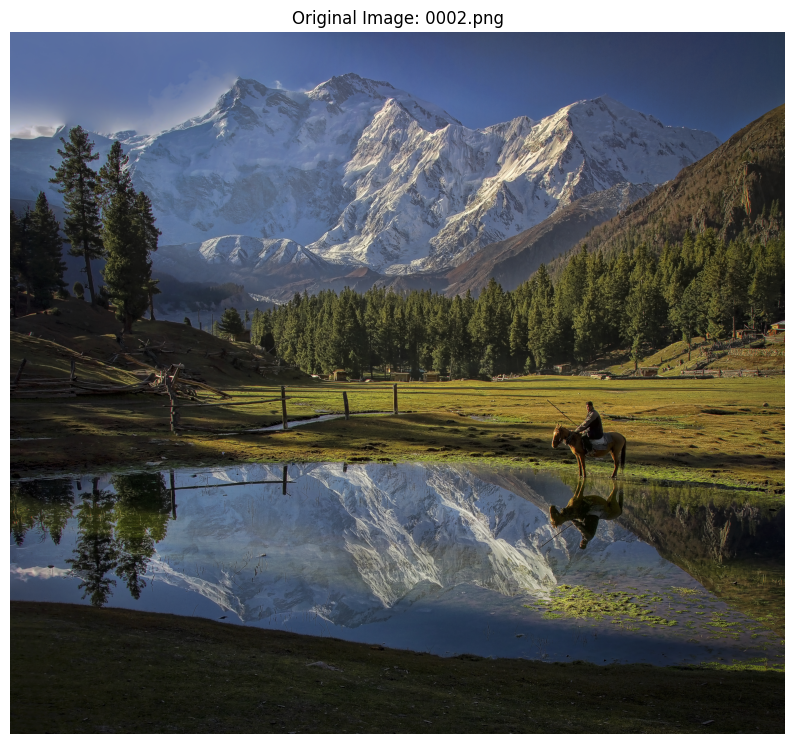

Image dimensions: 1848x2040, 3 channels


In [3]:
# Choose a random image to train on
img_file_path = '0002.png'
img_path = os.path.join(data_folder, img_file_path)
img_original = Image.open(img_path)

# Convert image to numpy array
img_np_original = np.array(img_original)

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(img_np_original)
plt.axis("off")
plt.title(f"Original Image: {img_file_path}")
plt.show()

# Get image dimensions
height_target, width_target, channels = img_np_original.shape
print(f"Image dimensions: {height_target}x{width_target}, {channels} channels")

In [4]:
class ImageDataset(Dataset):
    def __init__(self, coordinates, pixel_values):
        self.coordinates = coordinates.astype(np.float32)
        self.pixel_values = pixel_values.astype(np.float32)
    
    def __len__(self):
        return len(self.coordinates)
    
    def __getitem__(self, idx):
        coord = self.coordinates[idx]
        pixel = self.pixel_values[idx]
        return coord, pixel
    
class INRModel(nn.Module):
    def __init__(self, input_dim=2, output_dim=3, hidden_dim=256, num_layers=4, dropout_rate=0.5):
        super().__init__()
        
        layers = []
        # First layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())  # Ensure output is in [0, 1] range since the rgb values are normalized
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)
    
    def train_model(self, dataloader, num_epochs = 100, lr = 1e-3, device = 'cpu' if not torch.cuda.is_available() else 'cuda', criterion = nn.MSELoss(), optimizer = None):
        if optimizer is None:
            optimizer = optim.AdamW(self.parameters(), lr=lr)
        self.train()
        self.to(device)
        
        losses = []
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0
            
            for batch_coords, batch_pixels in dataloader:
                batch_coords = batch_coords.to(device)
                batch_pixels = batch_pixels.to(device)
                
                # Forward pass
                pred_pixels = self(batch_coords)
                
                # Compute loss
                loss = criterion(pred_pixels, batch_pixels)
                total_loss += loss.item()
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            avg_loss = total_loss / len(dataloader)
            losses.append(avg_loss)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")
        
        return losses
    
class Sine(nn.Module):
    def __init__(self, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        
    def forward(self, x):
        return torch.sin(self.omega_0 * x)

class BabySINE(nn.Module):
    def __init__(self, 
                 input_dim=2, 
                 output_dim=3,
                 hidden_dim=256,
                 num_layers=4,
                 omega_0=30,
                 sigma=10.0,
                 use_dropout=False,
                 dropout_rate=0.1):
        super().__init__()
        self.sigma = sigma
        self.omega_0 = omega_0
        
        layers = []
        # Input layer with sine activation
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(Sine(omega_0))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(Sine())
            if use_dropout:
                layers.append(nn.Dropout(dropout_rate))
        
        # Final output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())  # Keep output in [0,1] for RGB
        
        self.network = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        """SIREN-style weight initialization"""
        with torch.no_grad():
            for idx, layer in enumerate(self.network):
                if isinstance(layer, nn.Linear):
                    # Calculate fan_in
                    fan_in = layer.weight.size(1)
                    
                    # First layer initialization
                    if idx == 0:  # First linear layer
                        bound = 1 / fan_in
                    else:
                        bound = torch.sqrt(torch.tensor(6.0 / fan_in)) / self.omega_0
                        
                    # Uniform initialization
                    nn.init.uniform_(layer.weight, -bound, bound)
                    nn.init.zeros_(layer.bias)

    def forward(self, x, sigma=None):
        """Forward pass with optional sigma scaling"""
        if sigma is None:
            sigma = self.sigma
        # Scale input coordinates by sigma
        x = x * sigma
        return self.network(x)

    def train_model(self, 
                    dataloader, 
                    num_epochs=100, 
                    lr=1e-4, 
                    device='cuda' if torch.cuda.is_available() else 'cpu',
                    criterion=nn.MSELoss(),
                    sigma=10.0):
        
        optimizer = optim.Adam(self.parameters(), lr=lr)
        self.train()
        self.to(device)
        
        losses = []
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0
            
            for batch_coords, batch_pixels in dataloader:
                batch_coords = batch_coords.to(device)
                batch_pixels = batch_pixels.to(device)
                
                # Forward pass with sigma scaling
                pred_pixels = self(batch_coords, sigma)
                
                # Compute loss
                loss = criterion(pred_pixels, batch_pixels)
                total_loss += loss.item()
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            avg_loss = total_loss / len(dataloader)
            losses.append(avg_loss)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")
        
        return losses

In [5]:
def plot_image(image, title=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"{title} Image: ")
    plt.show()

    # Get image dimensions
    height_target, width_target, channels = image.shape
    print(f"Image dimensions: {height_target}x{width_target}, {channels} channels")


def pixel_coordinates_normalized(image, downsize_factor): 
    print(f"The original image has shape: {image.shape}")
    x, y = image.shape[:2]
    resized_image = cv.resize(image, (y // downsize_factor, x // downsize_factor))
    resized_x, resized_y = resized_image.shape[:2]
    xs = np.linspace(0, 1, resized_x)  # x coordinates (0 to 1)
    ys = np.linspace(0, 1, resized_y)  # y coordinates (0 to 1)

    xx, yy = np.meshgrid(xs, ys, indexing="ij")
    coordinates = np.stack((xx, yy), axis=-1)
    coordinates = coordinates.reshape(-1, 2) 
    resized_image = resized_image/255.0
    norm_resized_image = (resized_image - np.mean(resized_image)) / np.std(resized_image)
    pixel_values = norm_resized_image.reshape(-1, 3)
    
    return coordinates, pixel_values, norm_resized_image, resized_x, resized_y



In [6]:
image = np.array(img_np_original)
downsize_factor = 5
coordinates, pixel_values, norm_image, x, y = pixel_coordinates_normalized(image, downsize_factor)

print(f"Downsize factor: {downsize_factor}")

The original image has shape: (1848, 2040, 3)
Downsize factor: 5


In [7]:
# Create dataset and dataloader
dataset = ImageDataset(coordinates, pixel_values)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)


In [8]:
# # Create and train the model

on_mac = True
if on_mac:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.MSELoss()
channels = 3

# model = INRModel(input_dim=2, output_dim=channels, hidden_dim=128, num_layers=3, dropout_rate=0.5)


# # Plot the loss curve
# plt.figure(figsize=(10, 4))
# plt.plot(losses)
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.grid(True)
# plt.show()

  0%|          | 1/300 [00:00<03:20,  1.49it/s]

Epoch 0, Loss: 1.179733


  4%|▎         | 11/300 [00:07<03:21,  1.43it/s]

Epoch 10, Loss: 0.597666


  7%|▋         | 21/300 [00:14<03:17,  1.42it/s]

Epoch 20, Loss: 0.586720


 10%|█         | 31/300 [00:21<03:08,  1.43it/s]

Epoch 30, Loss: 0.581557


 14%|█▎        | 41/300 [00:28<02:56,  1.47it/s]

Epoch 40, Loss: 0.578317


 17%|█▋        | 51/300 [00:35<02:53,  1.43it/s]

Epoch 50, Loss: 0.575621


 20%|██        | 61/300 [00:43<02:49,  1.41it/s]

Epoch 60, Loss: 0.573495


 24%|██▎       | 71/300 [00:50<02:41,  1.42it/s]

Epoch 70, Loss: 0.571131


 27%|██▋       | 81/300 [00:57<02:33,  1.43it/s]

Epoch 80, Loss: 0.569111


 30%|███       | 91/300 [01:04<02:24,  1.45it/s]

Epoch 90, Loss: 0.567098


 34%|███▎      | 101/300 [01:11<02:19,  1.43it/s]

Epoch 100, Loss: 0.565140


 37%|███▋      | 111/300 [01:18<02:18,  1.37it/s]

Epoch 110, Loss: 0.563265


 40%|████      | 121/300 [01:25<02:14,  1.33it/s]

Epoch 120, Loss: 0.560848


 44%|████▎     | 131/300 [01:33<02:08,  1.32it/s]

Epoch 130, Loss: 0.558846


 47%|████▋     | 141/300 [01:40<01:59,  1.33it/s]

Epoch 140, Loss: 0.556917


 50%|█████     | 151/300 [01:47<01:43,  1.44it/s]

Epoch 150, Loss: 0.554568


 54%|█████▎    | 161/300 [01:55<01:42,  1.35it/s]

Epoch 160, Loss: 0.552687


 57%|█████▋    | 171/300 [02:02<01:31,  1.41it/s]

Epoch 170, Loss: 0.550902


 60%|██████    | 181/300 [02:09<01:31,  1.30it/s]

Epoch 180, Loss: 0.549499


 64%|██████▎   | 191/300 [02:16<01:14,  1.46it/s]

Epoch 190, Loss: 0.547976


 67%|██████▋   | 201/300 [02:23<01:09,  1.43it/s]

Epoch 200, Loss: 0.547124


 70%|███████   | 211/300 [02:30<01:05,  1.35it/s]

Epoch 210, Loss: 0.545823


 74%|███████▎  | 221/300 [02:38<01:00,  1.30it/s]

Epoch 220, Loss: 0.544501


 77%|███████▋  | 231/300 [02:46<00:50,  1.36it/s]

Epoch 230, Loss: 0.544259


 80%|████████  | 241/300 [02:53<00:44,  1.33it/s]

Epoch 240, Loss: 0.545377


 84%|████████▎ | 251/300 [03:01<00:36,  1.36it/s]

Epoch 250, Loss: 0.543566


 87%|████████▋ | 261/300 [03:08<00:29,  1.33it/s]

Epoch 260, Loss: 0.542031


 90%|█████████ | 271/300 [03:16<00:21,  1.34it/s]

Epoch 270, Loss: 0.542728


 94%|█████████▎| 281/300 [03:23<00:14,  1.31it/s]

Epoch 280, Loss: 0.542300


 97%|█████████▋| 291/300 [03:31<00:07,  1.26it/s]

Epoch 290, Loss: 0.541399


100%|██████████| 300/300 [03:38<00:00,  1.37it/s]


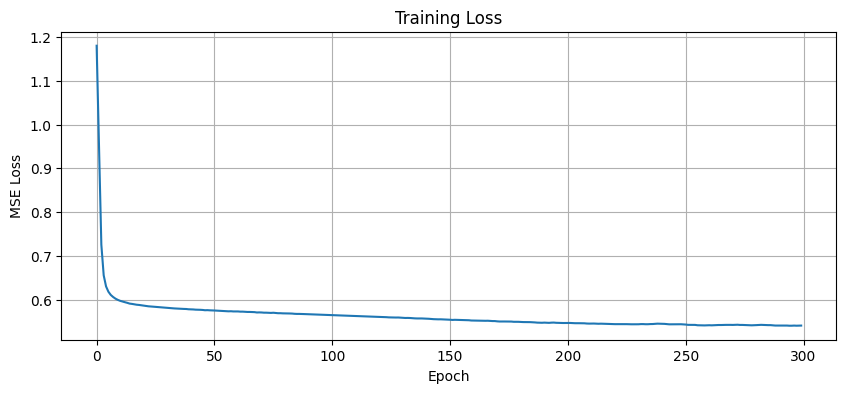

In [9]:
# Initialize model with DEFAULT parameters (sigma=10.0 built into model)
model = BabySINE(sigma=10.0, omega_0=15).to(device)  # sigma here sets DEFAULT value, can be overridden in training

# Single training process with progressive sigma scaling
losses = model.train_model(
    dataloader,
    num_epochs=300,  # Total epochs (100 + 200)
    lr=1e-4,
    sigma=10.0,  # Starting sigmas   
    #sigma_decay=None
)

# Plot the loss curve

plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

Max and Min values of pred_pixels: 1.0, 1.1274845945763445e-08


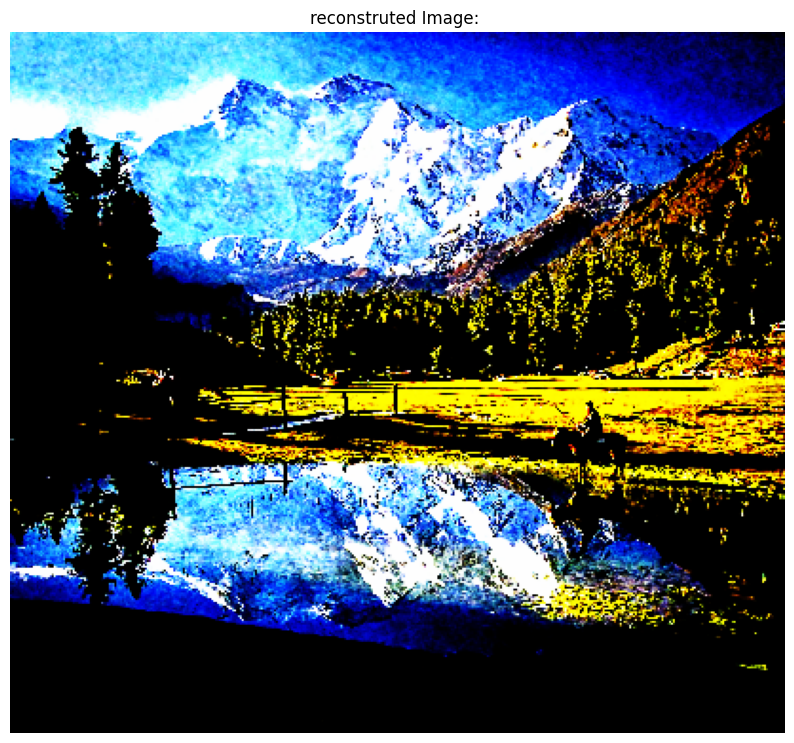

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5894409462787824..3.948114129809093].


Image dimensions: 369x408, 3 channels


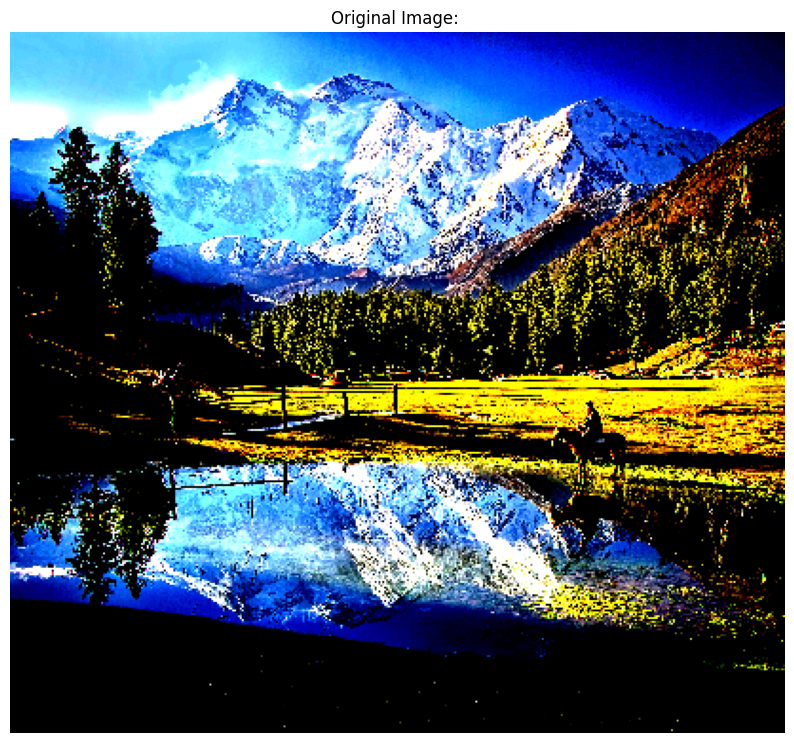

Image dimensions: 369x408, 3 channels
Downsized image shape: (369, 408, 3)
Reconstructed image shape: (369, 408, 3)
Original image shape: (369, 408, 3)


In [10]:
target_coords_tensor = torch.from_numpy(coordinates).float().to(device)
model = model.to(device)
# Use the trained model to predict the RGB values for these coordinates
with torch.no_grad():
    pred_pixels = model(target_coords_tensor).cpu().numpy()
    
print(f"Max and Min values of pred_pixels: {np.max(pred_pixels)}, {np.min(pred_pixels)}")

reconstructed_img_reshaped_normalized = pred_pixels.reshape(x, y, channels)
reconstructed_img_reshaped_denormalized = (reconstructed_img_reshaped_normalized * 255).astype(np.uint8)
reconstructed_img_reshaped_denormalized = np.clip(reconstructed_img_reshaped_denormalized, 0, 255)
plot_image(reconstructed_img_reshaped_denormalized, 'reconstruted')
plot_image(norm_image, 'Original')
# Check that the shapes of the reconstructed image and original image are the same

print(f"Downsized image shape: {norm_image.shape}")
print(f"Reconstructed image shape: {reconstructed_img_reshaped_denormalized.shape}")
print(f"Original image shape: {norm_image.shape}")